<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_04_01_survival_analysis_andersen_gill_model_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 4.1 Andersen-Gill (AG) Model


The Andersen-Gill (AG) model is a popular approach for analyzing recurrent event data using the counting process framework. It extends the Cox proportional hazards model to handle multiple events per subject by treating each event as a separate observation while accounting for the correlation of events within subjects through robust variance estimation.The AG model is an extension of the Cox PH model that treats recurrent events as independent observations within a subject, adjusted for intra-subject correlation using a robust variance estimator (clustering by subject ID). It assumes that the hazard for each event depends on covariates and the time since the study start (or a reset time). It treats each event as a separate observation while accounting for the at-risk time between events using a **counting process framework**.

This tutorial will:

- Explain the Andersen-Gill model
- Show how to prepare data in R
- Fit the model using `survival` package
- Perform diagnostics
- Compute and plot the **Cumulative Incidence Function (CIF)**
- Provide interpretation and best practices



## Overview



The AG model assumes that:

- Events follow a **non-homogeneous Poisson process**.
- The hazard for the *k*-th event depends on **calendar time** (not time since last event).
- All events from the same subject are **conditionally independent** given covariates (though robust standard errors account for within-subject correlation).


### Hazard Function


Hazard for the *i*-th subject at time *t*:

$$
h_i(t) = h_0(t) \exp(\beta^T X_i(t))
$$

Where:

- $h_0(t)$: baseline hazard (common to all events)
- $X_i(t)$: possibly time-varying covariates
- Each subject contributes **multiple rows** to the dataset (one per event or risk interval)


### Key Assumptions


- Proportional hazards over **calendar time**
- Events are **independent conditional on covariates** (robust SEs relax this)
- No terminal event that stops the process (e.g., death may need special handling)

**Note**: If a terminal event (like death) prevents further recurrences, consider **joint modeling** or **competing risks** approaches instead.


## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316568 sha256=767480574d7ed4bace1c187eb5156170fde96b4a226cd8f7002f1a4e8af75b95
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [2]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Implementation in R

We’ll use the built-in `readmission`-like data. Since R doesn’t include a standard recurrent event dataset, we’ll simulate one or use the `tcut` example from the `survival` package.


### Install Required R Packages

In [3]:
%%R
packages <-c(
		 'tidyverse',
		 'survival',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'ggfortify',
		 'timereg',
		 'cmprsk',
		 'riskRegression',
		 'reda'
		 )


### Install missing packages

In [ ]:
%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis", lib='drive/My Drive/R/')

### Verify installation

In [4]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method        from 
  nobs.multinom broom



     tidyverse       survival      survminer      ggsurvfit     tidycmprsk 
          TRUE           TRUE           TRUE           TRUE           TRUE 
     ggfortify        timereg         cmprsk riskRegression           reda 
          TRUE           TRUE           TRUE           TRUE           TRUE 


### Load Packages

In [5]:
%%R
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

In [6]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

Successfully loaded packages:
 [1] "package:reda"           "package:riskRegression" "package:cmprsk"        
 [4] "package:timereg"        "package:ggfortify"      "package:tidycmprsk"    
 [7] "package:ggsurvfit"      "package:survminer"      "package:ggpubr"        
[10] "package:survival"       "package:lubridate"      "package:forcats"       
[13] "package:stringr"        "package:dplyr"          "package:purrr"         
[16] "package:readr"          "package:tidyr"          "package:tibble"        
[19] "package:ggplot2"        "package:tidyverse"      "package:tools"         
[22] "package:stats"          "package:graphics"       "package:grDevices"     
[25] "package:utils"          "package:datasets"       "package:methods"       
[28] "package:base"          


### Data


We use the `surviva`l package and `bladder1` dataset, which contains recurrent bladder tumor data. The data set contains multiple rows per patient, with start and stop times for each interval, event indicators, and covariates.

`id`:	Patient id
`treatment`:	Placebo, pyridoxine (vitamin B6), or thiotepa
`number`:	Initial number of tumours (8=8 or more)
`size`:	Size (cm) of largest initial tumour
`recur`:	Number of recurrences
`start,stop`:	The start and end time of each time interval
`status`:	End of interval code, 0=censored, 1=recurrence, 2=death from bladder disease, 3=death other/unknown cause
`rtumor`:	Number of tumors found at the time of a recurrence
`rsize`:	Size of largest tumor at a recurrence
`enum`:	Event number (observation number within patient)


In [7]:
%%R
# Load bladder1 (long format)
data(bladder1)
str(bladder1)

'data.frame':	294 obs. of  11 variables:
 $ id       : int  1 2 3 4 5 6 6 7 8 9 ...
 $ treatment: Factor w/ 3 levels "placebo","pyridoxine",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ number   : int  1 1 2 1 5 4 4 1 1 1 ...
 $ size     : int  1 3 1 1 1 1 1 1 1 3 ...
 $ recur    : int  0 0 0 0 0 1 1 0 0 1 ...
 $ start    : int  0 0 0 0 0 0 6 0 0 0 ...
 $ stop     : int  0 1 4 7 10 6 10 14 18 5 ...
 $ status   : num  3 3 0 0 3 1 3 0 0 1 ...
 $ rtumor   : chr  "." "." "." "." ...
 $ rsize    : chr  "." "." "." "." ...
 $ enum     : num  1 1 1 1 1 1 2 1 1 1 ...


### Data Preparation


We will create gaptime for PWP-GT and truncate to the first 4 events for stable risk sets:


In [8]:
%%R
# Identify problematic rows
invalid_intervals <- bladder1[bladder1$stop <= bladder1$start, ]
invalid_status <- bladder1[!bladder1$status %in% c(0, 1), ]

# Remove invalid rows
bladder1_clean <- bladder1 %>%
  filter(stop > start, status %in% c(0, 1))

# Create gaptime for PWP-GT
bladder1_clean <- bladder1_clean %>%
  group_by(id) %>%
  mutate(gaptime = stop - start) %>%
  ungroup()

# Truncate to first 4 events for PWP models
bladder_trunc <- bladder1_clean[bladder1_clean$enum <= 4, ]

# Verify
head(bladder_trunc)

# A tibble: 6 × 12
     id treatment number  size recur start  stop status rtumor rsize  enum
  <int> <fct>      <int> <int> <int> <int> <int>  <dbl> <chr>  <chr> <dbl>
1     3 placebo        2     1     0     0     4      0 .      .         1
2     4 placebo        1     1     0     0     7      0 .      .         1
3     6 placebo        4     1     1     0     6      1 1      1         1
4     7 placebo        1     1     0     0    14      0 .      .         1
5     8 placebo        1     1     0     0    18      0 .      .         1
6     9 placebo        1     3     1     0     5      1 2      4         1
# ℹ 1 more variable: gaptime <int>


###  Fit the Andersen-Gill Model


Use `coxph()` with a **Surv(tstart, tstop, event)** object:


In [9]:
%%R
# Fit AG model
ag_model <- coxph(Surv(start, stop, status) ~ treatment + number + size + cluster(id),
                data = bladder_trunc, robust = TRUE)

summary(ag_model)

Call:
coxph(formula = Surv(start, stop, status) ~ treatment + number + 
    size, data = bladder_trunc, robust = TRUE, cluster = id)

  n= 216, number of events= 149 

                         coef exp(coef)  se(coef) robust se      z Pr(>|z|)   
treatmentpyridoxine -0.136192  0.872675  0.202938  0.317218 -0.429  0.66768   
treatmentthiotepa   -0.375981  0.686615  0.200102  0.261779 -1.436  0.15093   
number               0.164861  1.179229  0.038932  0.055719  2.959  0.00309 **
size                 0.008494  1.008531  0.048500  0.070791  0.120  0.90449   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
treatmentpyridoxine    0.8727     1.1459    0.4686     1.625
treatmentthiotepa      0.6866     1.4564    0.4110     1.147
number                 1.1792     0.8480    1.0572     1.315
size                   1.0085     0.9915    0.8779     1.159

Concordance= 0.631  (se = 0.03 )
Likelihood ratio test= 17.22  

###  Model Diagnostics

#### Proportional Hazards Assumption


Use `cox.zph()`:


           chisq df    p
treatment 1.9536  2 0.38
number    0.0217  1 0.88
size      2.3347  1 0.13
GLOBAL    4.1808  4 0.38


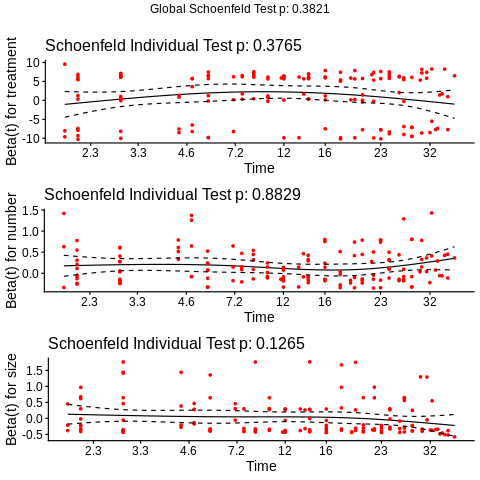

In [10]:
%%R
zph_test <- cox.zph(ag_model)
print(zph_test)
ggcoxzph(zph_test)  # plot


>  If p < 0.05 for a covariate, PH assumption may be violated. Consider time-interactions (e.g., `tt()` function).


#### Residuals


Check martingale or deviance residuals (less common for recurrent events):


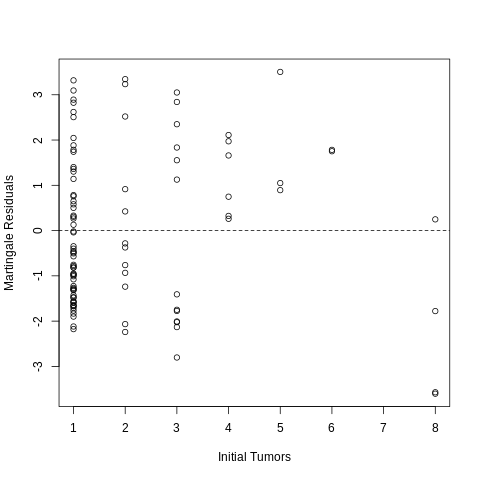

In [11]:
%%R
mart_res <- residuals(ag_model, type = "martingale", collapse = bladder_trunc$id)
plot(mart_res ~ bladder_trunc$number[match(names(mart_res), bladder_trunc$id)],
     xlab = "Initial Tumors", ylab = "Martingale Residuals")
abline(h = 0, lty = 2)

### Compute and Plot Cumulative Incidence Function (CIF)


While the AG model estimates **hazard ratios**, the **Cumulative Incidence Function (CIF)** shows the **expected number of events** over time.


The **Cumulative Incidence Function (CIF)** is a key concept in **survival analysis**, particularly in the context of **competing risks**—situations where multiple distinct types of events can occur, and the occurrence of one event precludes the others.

The Cumulative Incidence Function for a specific event type \( k \) at time \( t \) is defined as:

$$
\text{CIF}_k(t) = P(T \leq t \text{ and event type } = k)
$$
In words:  

$CIF(_k)(t)$ is the probability that an individual experiences event type $k$ by time $t$, in the presence of other competing event types.

This differs from the standard **Kaplan-Meier (KM) estimator**, which treats all other event types as censored. In competing risks settings, censoring competing events leads to **overestimation** of the event probability, because it assumes those individuals could still experience the event of interest later—which is not true if a competing event (e.g., death from another cause) has already occurred.



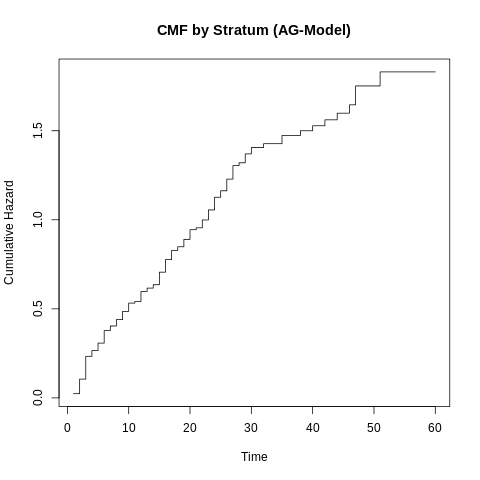

In [12]:
%%R
base_ag <- basehaz(ag_model, centered = FALSE)
plot(base_ag$hazard ~ base_ag$time, type = "s", xlab = "Time", ylab = "Cumulative Hazard",
     main = "CMF by Stratum (AG-Model)")

## Summary & Conclusion


The Andersen-Gill (AG) model is appropriate when subjects experience multiple events of the same type—such as hospital readmissions or recurrent infections—and there is no terminal event (like death) that permanently stops the event process (or if such an event is handled separately). It is particularly useful when the research question focuses on the **event rate** over calendar time rather than the time between successive events. Among its strengths, the AG model is a straightforward extension of the standard Cox proportional hazards model, naturally accommodates time-varying covariates, and uses robust (sandwich) standard errors to account for within-subject correlation across recurrent events. However, it has important limitations: it assumes that, conditional on covariates, recurrent events are independent, and it does not explicitly model dependence on event history—such as changes in risk based on the number of prior events or the gap time since the last event. Additionally, the model may be inappropriate when a terminal event truncates follow-up, as it does not inherently account for this competing risk. In such cases, alternative approaches should be considered, including the **Prentice-Williams-Peterson (PWP) model** (which stratifies by event order and can model gap or total times), **frailty models** (which incorporate random effects to capture unobserved subject-specific heterogeneity), or **joint models** that simultaneously analyze recurrent events and associated terminal events like death.




## Resources


 **Books**
- *Modeling Survival Data: Extending the Cox Model* by Terry M. Therneau & Patricia M. Grambsch  
- *The Statistical Analysis of Recurrent Events* by Richard J. Cook & Jerald F. Lawless

**R Packages**
- [`survival`](https://cran.r-project.org/package=survival): Core survival analysis
- [`reda`](https://cran.r-project.org/package=reda): Recurrent event data analysis (MCF, simulation)
- [`frailtypack`](https://cran.r-project.org/package=frailtypack): Frailty models for recurrent events

**Vignettes & Tutorials**
- `vignette("timedep", package = "survival")`
- `vignette("reda-MCF", package = "reda")`
- Therneau’s [Survival Analysis Tutorial](https://cran.r-project.org/web/packages/survival/vignettes/timedep.pdf)


